# Visualization Of Live Trading Session

### 1. Importing all the required modules

In [87]:
from docopt import docopt
from trading_bot.ops import get_state
from trading_bot.agent import Agent
from trading_bot.methods import evaluate_model
from trading_bot.utils import (
    get_stock_data,
    format_currency,
    format_position,
    show_eval_result,
    switch_k_backend_device
)
import logging
import coloredlogs
import lxml.html as lh
import time
import urllib.request
import datetime
import pytz
from selenium import webdriver
from selenium.common.exceptions import StaleElementReferenceException
tz = pytz.timezone('Asia/Kolkata')

ignored_exceptions=(StaleElementReferenceException,)
options = webdriver.ChromeOptions()
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--headless')
options.add_experimental_option('excludeSwitches', ['enable-logging'])
driver = webdriver.Chrome(executable_path="C:\\Program Files (x86)\\Google\\Chrome\\chromedriver.exe" , options=options)



2020-05-22 12:44:42 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session {"capabilities": {"firstMatch": [{}], "alwaysMatch": {"browserName": "chrome", "platformName": "any", "goog:chromeOptions": {"excludeSwitches": ["enable-logging"], "extensions": [], "args": ["--no-sandbox", "--disable-dev-shm-usage", "--headless"]}}}, "desiredCapabilities": {"browserName": "chrome", "version": "", "platform": "ANY", "goog:chromeOptions": {"excludeSwitches": ["enable-logging"], "extensions": [], "args": ["--no-sandbox", "--disable-dev-shm-usage", "--headless"]}}}
2020-05-22 12:44:42 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG Starting new HTTP connection (1): 127.0.0.1:53549
2020-05-22 12:44:44 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session HTTP/1.1" 200 722
2020-05-22 12:44:44 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


### 2. Function to scrap real time value from website

In [88]:
def Real(url,count):
    if count == 0:
        
        driver.get(url)

    else:
        driver.refresh()
        time.sleep(15)

    infile = driver.page_source
    doc = lh.fromstring(infile)
    live = doc.xpath('/html/body/div[1]/div/div/div[1]/div/div[2]/div/div/div[4]/div/div/div/div[3]/div/div/span[1]')
    live = float(live[0].text.replace(',',''))
    return live 

### 3. Model Evaluation function

In [89]:
def evaluate_model(agent, state, next_state, data, t, total_profit, history, reward, window_size, debug=False):
  
    print(t)
        # select an action
    action = agent.act(state, is_eval=True)

        # BUY
    if action == 1:
        agent.inventory.append(data[t])

        history.append([data[t], "BUY",datetime.datetime.now(tz).time()])
        if debug:
            logging.debug("Buy at: {}".format(format_currency(data[t])))

        # SELL
    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        delta = data[t] - bought_price
        reward = delta #max(delta, 0)
        total_profit += delta

        history.append([data[t], "SELL",datetime.datetime.now(tz).time()])
        if debug:
            logging.debug("Sell at: {} | Position: {}".format(
                    format_currency(data[t]), format_position(data[t] - bought_price)))
        # HOLD
    else:
        history.append([data[t], "HOLD",datetime.datetime.now(tz).time()])

#        done = (t == data_length - 1)
    agent.memory.append((state, action, reward, next_state))

    return total_profit

### 4. The Main function to execute scraping and evaluation

In [90]:
def main(args):
    count = 0
    total_profit = 0
    t=0
    history = []
    reward = 0
    ticker = args + '.NS'
    price = []
    window_size =10
    time_now = datetime.datetime.now(tz).time()

    #Total Iterations
    total_count = 100
    
    while(count<total_count):
        url = 'https://finance.yahoo.com/quote/{}?p={}&.tsrc=fin-srch'.format(ticker,ticker)
        print(count)
        live = Real(url,count)
        count+=1        
        price.append(live)
        if count < window_size:
           continue
        model_name='model_debug_50'  
        print(live)
        initial_offset = price[1] - price[0]
        state = get_state(price, 0, window_size + 1)
        next_state = get_state(price, t + 1, window_size + 1)
        agent = Agent(state_size=window_size, pretrained=True, model_name=model_name)
        agent.inventory = []
        profit = evaluate_model(agent,state,next_state, price, t, total_profit, history, reward, window_size=window_size)
        show_eval_result(model_name, profit, initial_offset)
        t+=1
        state = next_state
        
    return history

### 5. Running the live trading session

In [91]:
coloredlogs.install(level="DEBUG")
switch_k_backend_device()
#Company Name
company = "RELIANCE"
data = main(company)

2020-05-22 12:45:08 DESKTOP-OCEF6E1 root[9272] DEBUG switching to TensorFlow for CPU


0


2020-05-22 12:45:08 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/url {"url": "https://finance.yahoo.com/quote/RELIANCE.NS?p=RELIANCE.NS&.tsrc=fin-srch"}
2020-05-22 12:45:12 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/url HTTP/1.1" 200 14
2020-05-22 12:45:12 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:45:12 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:45:12 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 847631
2020-05-22 12:45:13 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1


2020-05-22 12:45:13 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:45:14 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:45:14 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:45:29 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:45:29 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887116
2020-05-22 12:45:29 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


2


2020-05-22 12:45:30 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:45:31 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:45:31 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:45:46 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:45:46 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888240
2020-05-22 12:45:46 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


3


2020-05-22 12:45:46 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:45:47 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:45:47 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:46:02 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:46:02 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887128
2020-05-22 12:46:02 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


4


2020-05-22 12:46:02 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:46:03 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:46:03 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:46:19 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:46:19 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888218
2020-05-22 12:46:19 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


5


2020-05-22 12:46:19 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:46:20 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:46:20 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:46:35 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:46:35 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887430
2020-05-22 12:46:35 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


6


2020-05-22 12:46:35 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:46:37 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:46:37 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:46:52 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:46:52 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887355
2020-05-22 12:46:52 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


7


2020-05-22 12:46:52 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:46:53 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:46:53 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:47:08 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:47:08 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887130
2020-05-22 12:47:08 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


8


2020-05-22 12:47:09 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:47:10 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:47:10 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:47:25 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:47:25 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887269
2020-05-22 12:47:25 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


9


2020-05-22 12:47:25 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:47:26 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:47:26 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:47:41 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:47:41 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887262
2020-05-22 12:47:41 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.65
0


2020-05-22 12:47:42 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



10


2020-05-22 12:47:42 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:47:43 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:47:43 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:47:59 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:47:59 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887129
2020-05-22 12:47:59 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.5
1


2020-05-22 12:48:00 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



11


2020-05-22 12:48:00 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:48:01 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:48:01 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:48:16 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:48:16 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888209
2020-05-22 12:48:16 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1434.4
2


2020-05-22 12:48:17 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



12


2020-05-22 12:48:17 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:48:18 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:48:18 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:48:33 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:48:33 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887413
2020-05-22 12:48:33 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1434.45
3


2020-05-22 12:48:34 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



13


2020-05-22 12:48:34 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:48:35 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:48:35 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:48:50 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:48:50 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886963
2020-05-22 12:48:51 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.8
4


2020-05-22 12:48:51 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



14


2020-05-22 12:48:51 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:48:53 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:48:53 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:49:08 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:49:08 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886994
2020-05-22 12:49:08 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.25
5


2020-05-22 12:49:09 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



15


2020-05-22 12:49:09 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:49:10 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:49:10 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:49:25 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:49:26 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886954
2020-05-22 12:49:26 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1434.4
6


2020-05-22 12:49:27 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



16


2020-05-22 12:49:27 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:49:27 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:49:27 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:49:43 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:49:43 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886971
2020-05-22 12:49:43 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.45
7


2020-05-22 12:49:43 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



17


2020-05-22 12:49:44 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:49:45 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:49:45 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:50:00 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:50:00 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888070
2020-05-22 12:50:00 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.5
8


2020-05-22 12:50:01 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



18


2020-05-22 12:50:01 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:50:03 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:50:03 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:50:18 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:50:18 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888316
2020-05-22 12:50:18 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1434.25
9


2020-05-22 12:50:19 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



19


2020-05-22 12:50:19 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:50:20 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:50:20 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:50:35 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:50:35 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888077
2020-05-22 12:50:35 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1434.25
10


2020-05-22 12:50:36 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



20


2020-05-22 12:50:36 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:50:38 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:50:38 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:50:53 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:50:53 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886994
2020-05-22 12:50:53 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1434.7
11


2020-05-22 12:50:54 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



21


2020-05-22 12:50:54 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:50:55 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:50:55 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:51:10 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:51:10 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887987
2020-05-22 12:51:10 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1434.4
12


2020-05-22 12:51:11 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



22


2020-05-22 12:51:11 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:51:12 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:51:12 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:51:27 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:51:27 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887029
2020-05-22 12:51:27 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.85
13


2020-05-22 12:51:28 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



23


2020-05-22 12:51:28 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:51:30 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:51:30 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:51:45 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:51:45 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888046
2020-05-22 12:51:45 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.05
14


2020-05-22 12:51:46 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



24


2020-05-22 12:51:46 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:51:47 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:51:47 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:52:02 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:52:02 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886969
2020-05-22 12:52:02 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1431.3
15


2020-05-22 12:52:05 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



25


2020-05-22 12:52:05 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:52:06 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:52:06 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:52:21 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:52:21 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887090
2020-05-22 12:52:21 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1426.95
16


2020-05-22 12:52:22 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



26


2020-05-22 12:52:22 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:52:23 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:52:23 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:52:38 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:52:39 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887129
2020-05-22 12:52:39 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1428.95
17


2020-05-22 12:52:39 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



27


2020-05-22 12:52:40 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:52:41 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:52:41 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:52:56 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:52:56 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886976
2020-05-22 12:52:56 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1428.45
18


2020-05-22 12:52:57 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



28


2020-05-22 12:52:57 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:52:58 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:52:58 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:53:13 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:53:13 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888065
2020-05-22 12:53:13 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1427.55
19


2020-05-22 12:53:14 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



29


2020-05-22 12:53:14 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:53:15 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:53:15 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:53:30 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:53:30 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888044
2020-05-22 12:53:30 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1427.85
20


2020-05-22 12:53:31 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



30


2020-05-22 12:53:31 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:53:32 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:53:32 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:53:47 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:53:47 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887028
2020-05-22 12:53:47 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1428.8
21


2020-05-22 12:53:48 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



31


2020-05-22 12:53:48 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:53:49 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:53:49 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:54:04 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:54:04 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887030
2020-05-22 12:54:04 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1430.0
22


2020-05-22 12:54:05 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



32


2020-05-22 12:54:05 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:54:06 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:54:06 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:54:21 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:54:21 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887181
2020-05-22 12:54:22 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1429.9
23


2020-05-22 12:54:22 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



33


2020-05-22 12:54:22 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:54:24 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:54:24 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:54:39 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:54:39 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888234
2020-05-22 12:54:39 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1430.6
24


2020-05-22 12:54:40 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



34


2020-05-22 12:54:40 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:54:41 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:54:41 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:54:56 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:54:56 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887048
2020-05-22 12:54:56 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1431.8
25


2020-05-22 12:54:57 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



35


2020-05-22 12:54:57 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:54:58 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:54:58 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:55:13 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:55:13 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888418
2020-05-22 12:55:13 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1431.5
26


2020-05-22 12:55:14 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



36


2020-05-22 12:55:14 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:55:15 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:55:15 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:55:30 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:55:30 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888068
2020-05-22 12:55:30 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1429.9
27


2020-05-22 12:55:31 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



37


2020-05-22 12:55:31 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:55:33 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:55:33 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:55:49 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:55:49 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887005
2020-05-22 12:55:49 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1428.0
28


2020-05-22 12:55:50 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



38


2020-05-22 12:55:50 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:55:51 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:55:51 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:56:06 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:56:06 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886998
2020-05-22 12:56:06 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1428.6
29


2020-05-22 12:56:07 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



39


2020-05-22 12:56:07 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:56:08 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:56:08 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:56:23 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:56:23 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887325
2020-05-22 12:56:23 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1429.0
30


2020-05-22 12:56:24 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



40


2020-05-22 12:56:24 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:56:25 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:56:25 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:56:40 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:56:40 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886914
2020-05-22 12:56:40 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1428.7
31


2020-05-22 12:56:41 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



41


2020-05-22 12:56:41 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:56:42 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:56:42 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:56:57 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:56:57 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886948
2020-05-22 12:56:58 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1428.0
32


2020-05-22 12:56:59 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



42


2020-05-22 12:56:59 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:57:00 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:57:00 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:57:15 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:57:15 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888325
2020-05-22 12:57:15 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1428.65
33


2020-05-22 12:57:16 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



43


2020-05-22 12:57:16 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:57:17 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:57:17 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:57:32 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:57:32 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886982
2020-05-22 12:57:32 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1429.15
34


2020-05-22 12:57:33 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



44


2020-05-22 12:57:33 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:57:34 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:57:34 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:57:49 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:57:49 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886959
2020-05-22 12:57:49 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1429.4
35


2020-05-22 12:57:50 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



45


2020-05-22 12:57:50 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:57:51 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:57:51 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:58:06 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:58:07 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888068
2020-05-22 12:58:07 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1430.35
36


2020-05-22 12:58:08 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



46


2020-05-22 12:58:08 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:58:09 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:58:09 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:58:24 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:58:24 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887169
2020-05-22 12:58:24 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.0
37


2020-05-22 12:58:25 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



47


2020-05-22 12:58:25 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:58:26 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:58:26 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:58:41 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:58:41 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887264
2020-05-22 12:58:41 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1430.3
38


2020-05-22 12:58:42 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



48


2020-05-22 12:58:42 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:58:43 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:58:43 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:58:58 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:58:58 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887291
2020-05-22 12:58:58 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1430.45
39


2020-05-22 12:58:59 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



49


2020-05-22 12:58:59 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:59:00 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:59:00 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:59:15 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:59:15 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888219
2020-05-22 12:59:15 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1430.05
40


2020-05-22 12:59:16 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



50


2020-05-22 12:59:16 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:59:17 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:59:17 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:59:32 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:59:32 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886993
2020-05-22 12:59:32 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1430.7
41


2020-05-22 12:59:33 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



51


2020-05-22 12:59:33 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:59:34 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:59:34 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 12:59:49 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 12:59:49 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888072
2020-05-22 12:59:49 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1430.6
42


2020-05-22 12:59:50 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



52


2020-05-22 12:59:50 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 12:59:51 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 12:59:51 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:00:06 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:00:06 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887002
2020-05-22 13:00:06 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1430.7
43


2020-05-22 13:00:07 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



53


2020-05-22 13:00:07 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:00:08 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:00:09 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:00:24 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:00:24 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886944
2020-05-22 13:00:24 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1431.1
44


2020-05-22 13:00:25 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



54


2020-05-22 13:00:25 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:00:26 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:00:26 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:00:41 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:00:41 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886978
2020-05-22 13:00:41 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1431.75
45


2020-05-22 13:00:42 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



55


2020-05-22 13:00:42 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:00:43 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:00:43 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:00:58 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:00:58 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886913
2020-05-22 13:00:58 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.0
46


2020-05-22 13:00:59 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



56


2020-05-22 13:00:59 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:01:00 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:01:00 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:01:15 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:01:16 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886956
2020-05-22 13:01:16 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1431.5
47


2020-05-22 13:01:17 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



57


2020-05-22 13:01:17 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:01:18 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:01:18 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:01:33 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:01:33 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887008
2020-05-22 13:01:33 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.0
48


2020-05-22 13:01:34 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



58


2020-05-22 13:01:34 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:01:35 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:01:35 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:01:50 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:01:50 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886974
2020-05-22 13:01:50 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.0
49


2020-05-22 13:01:51 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



59


2020-05-22 13:01:51 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:01:52 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:01:52 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:02:07 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:02:08 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886975
2020-05-22 13:02:08 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.35
50


2020-05-22 13:02:09 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



60


2020-05-22 13:02:09 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:02:10 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:02:10 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:02:25 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:02:25 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886997
2020-05-22 13:02:25 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.25
51


2020-05-22 13:02:26 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



61


2020-05-22 13:02:26 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:02:27 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:02:28 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:02:43 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:02:43 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886982
2020-05-22 13:02:43 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.5
52


2020-05-22 13:02:44 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



62


2020-05-22 13:02:44 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:02:46 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:02:46 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:03:01 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:03:01 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887202
2020-05-22 13:03:01 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.25
53


2020-05-22 13:03:02 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



63


2020-05-22 13:03:02 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:03:03 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:03:03 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:03:18 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:03:18 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887199
2020-05-22 13:03:18 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1431.8
54


2020-05-22 13:03:19 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



64


2020-05-22 13:03:19 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:03:20 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:03:20 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:03:35 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:03:36 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886937
2020-05-22 13:03:36 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.2
55


2020-05-22 13:03:36 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



65


2020-05-22 13:03:36 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:03:37 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:03:38 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:03:53 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:03:53 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887027
2020-05-22 13:03:53 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1431.65
56


2020-05-22 13:03:54 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



66


2020-05-22 13:03:54 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:03:55 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:03:55 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:04:10 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:04:10 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886892
2020-05-22 13:04:10 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1431.8
57


2020-05-22 13:04:11 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



67


2020-05-22 13:04:11 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:04:12 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:04:12 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:04:27 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:04:27 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886975
2020-05-22 13:04:27 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.05
58


2020-05-22 13:04:28 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



68


2020-05-22 13:04:28 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:04:29 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:04:29 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:04:44 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:04:44 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888185
2020-05-22 13:04:44 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.25
59


2020-05-22 13:04:45 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



69


2020-05-22 13:04:45 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:04:46 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:04:46 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:05:01 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:05:01 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887078
2020-05-22 13:05:01 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1431.0
60


2020-05-22 13:05:02 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



70


2020-05-22 13:05:02 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:05:03 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:05:03 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:05:19 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:05:19 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888016
2020-05-22 13:05:19 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1431.8
61


2020-05-22 13:05:20 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



71


2020-05-22 13:05:20 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:05:23 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:05:23 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:05:38 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:05:38 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 888046
2020-05-22 13:05:38 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.25
62


2020-05-22 13:05:39 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



72


2020-05-22 13:05:39 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:05:41 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:05:41 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:05:56 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:05:56 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887058
2020-05-22 13:05:56 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.25
63


2020-05-22 13:05:57 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



73


2020-05-22 13:05:57 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:05:59 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:05:59 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:06:14 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:06:14 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887014
2020-05-22 13:06:14 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.7
64


2020-05-22 13:06:15 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



74


2020-05-22 13:06:15 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:06:16 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:06:16 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:06:31 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:06:32 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887146
2020-05-22 13:06:32 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1434.7
65


2020-05-22 13:06:32 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



75


2020-05-22 13:06:33 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:06:34 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:06:34 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:06:49 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:06:49 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887028
2020-05-22 13:06:49 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1434.05
66


2020-05-22 13:06:50 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



76


2020-05-22 13:06:50 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:06:51 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:06:52 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:07:07 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:07:07 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 885757
2020-05-22 13:07:07 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1434.3
67


2020-05-22 13:07:08 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



77


2020-05-22 13:07:08 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:07:09 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:07:09 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:07:24 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:07:24 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886966
2020-05-22 13:07:24 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.6
68


2020-05-22 13:07:26 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



78


2020-05-22 13:07:26 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:07:27 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:07:27 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:07:42 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:07:42 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886978
2020-05-22 13:07:42 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.25
69


2020-05-22 13:07:43 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



79


2020-05-22 13:07:43 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:07:45 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:07:45 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:08:00 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:08:00 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886817
2020-05-22 13:08:00 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.2
70


2020-05-22 13:08:01 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



80


2020-05-22 13:08:01 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:08:03 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:08:03 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:08:18 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:08:18 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886992
2020-05-22 13:08:18 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.8
71


2020-05-22 13:08:19 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



81


2020-05-22 13:08:19 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:08:20 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:08:20 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:08:35 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:08:36 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886941
2020-05-22 13:08:36 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.55
72


2020-05-22 13:08:37 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



82


2020-05-22 13:08:37 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:08:38 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:08:38 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:08:53 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:08:54 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886942
2020-05-22 13:08:54 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.55
73


2020-05-22 13:08:55 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



83


2020-05-22 13:08:55 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:08:57 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:08:57 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:09:12 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:09:12 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886962
2020-05-22 13:09:12 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1431.7
74


2020-05-22 13:09:13 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



84


2020-05-22 13:09:13 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:09:16 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:09:16 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:09:31 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:09:31 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 885779
2020-05-22 13:09:31 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1431.5
75


2020-05-22 13:09:32 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



85


2020-05-22 13:09:32 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:09:34 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:09:34 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:09:49 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:09:49 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886961
2020-05-22 13:09:49 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.3
76


2020-05-22 13:09:50 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



86


2020-05-22 13:09:50 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:09:52 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:09:52 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:10:07 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:10:07 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886982
2020-05-22 13:10:07 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.75
77


2020-05-22 13:10:09 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



87


2020-05-22 13:10:09 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:10:11 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:10:11 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:10:26 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:10:26 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887091
2020-05-22 13:10:26 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.2
78


2020-05-22 13:10:27 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



88


2020-05-22 13:10:27 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:10:29 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:10:29 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:10:44 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:10:44 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887172
2020-05-22 13:10:44 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1434.2
79


2020-05-22 13:10:45 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



89


2020-05-22 13:10:45 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:10:47 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:10:47 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:11:02 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:11:02 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886962
2020-05-22 13:11:02 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.7
80


2020-05-22 13:11:04 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



90


2020-05-22 13:11:04 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:11:05 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:11:05 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:11:20 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:11:21 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887033
2020-05-22 13:11:21 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.7
81


2020-05-22 13:11:21 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



91


2020-05-22 13:11:22 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:11:23 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:11:23 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:11:38 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:11:38 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 886895
2020-05-22 13:11:38 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.3
82


2020-05-22 13:11:39 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



92


2020-05-22 13:11:39 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:11:40 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:11:40 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:11:55 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:11:55 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887831
2020-05-22 13:11:55 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.5
83


2020-05-22 13:11:57 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



93


2020-05-22 13:11:57 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:11:58 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:11:58 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:12:13 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:12:13 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 884938
2020-05-22 13:12:13 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.75
84


2020-05-22 13:12:14 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



94


2020-05-22 13:12:14 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:12:16 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:12:16 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:12:31 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:12:31 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 884702
2020-05-22 13:12:31 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.65
85


2020-05-22 13:12:33 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



95


2020-05-22 13:12:33 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:12:34 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:12:34 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:12:49 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:12:49 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 884736
2020-05-22 13:12:49 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.7
86


2020-05-22 13:12:51 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



96


2020-05-22 13:12:51 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:12:52 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:12:52 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:13:07 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:13:07 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 884970
2020-05-22 13:13:07 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.5
87


2020-05-22 13:13:09 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



97


2020-05-22 13:13:09 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:13:10 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:13:10 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:13:25 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:13:25 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 887005
2020-05-22 13:13:26 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1433.0
88


2020-05-22 13:13:27 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



98


2020-05-22 13:13:27 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:13:28 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:13:28 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:13:43 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:13:44 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 884711
2020-05-22 13:13:44 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.95
89


2020-05-22 13:13:45 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



99


2020-05-22 13:13:45 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG POST http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/refresh {}
2020-05-22 13:13:46 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "POST /session/ec1f55867f1557c357ff78c2590aad7c/refresh HTTP/1.1" 200 14
2020-05-22 13:13:46 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request
2020-05-22 13:14:01 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG GET http://127.0.0.1:53549/session/ec1f55867f1557c357ff78c2590aad7c/source {}
2020-05-22 13:14:01 DESKTOP-OCEF6E1 urllib3.connectionpool[9272] DEBUG http://127.0.0.1:53549 "GET /session/ec1f55867f1557c357ff78c2590aad7c/source HTTP/1.1" 200 884803
2020-05-22 13:14:01 DESKTOP-OCEF6E1 selenium.webdriver.remote.remote_connection[9272] DEBUG Finished Request


1432.05
90


2020-05-22 13:14:02 DESKTOP-OCEF6E1 root[9272] INFO model_debug_50: USELESS



### 6. Plotting the data

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

2020-05-22 13:16:33 DESKTOP-OCEF6E1 matplotlib.axes._base[9272] DEBUG update_title_pos
2020-05-22 13:16:33 DESKTOP-OCEF6E1 matplotlib.axes._base[9272] DEBUG update_title_pos
2020-05-22 13:16:33 DESKTOP-OCEF6E1 matplotlib.axes._base[9272] DEBUG update_title_pos
2020-05-22 13:16:33 DESKTOP-OCEF6E1 matplotlib.axes._base[9272] DEBUG update_title_pos


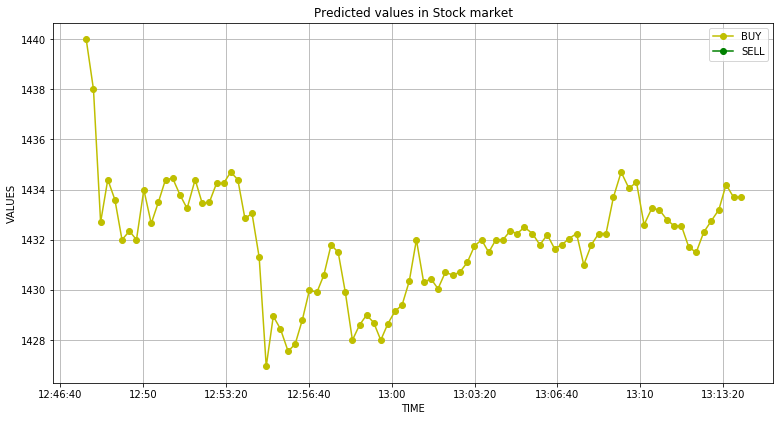

In [93]:
y1 = [x[0] for x in data if x[1] == "BUY"]
y2 = [x[0] for x in data if x[1] == "SELL"]
t1 = [x[2] for x in data if x[1] == "BUY"]
t2 = [x[2] for x in data if x[1] == "SELL"]
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.grid(True)
l1 = ax.plot(t1,y1,'yo-')
l2 = ax.plot(t2,y2,'go-')
ax.legend(labels = ('BUY', 'SELL'), loc = 'upper right')
ax.set_title("Predicted values in Stock market")
ax.set_xlabel('TIME')
ax.set_ylabel('VALUES')
plt.show()